<a href="https://colab.research.google.com/github/shepnst/Database-implementation/blob/main/homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, datasets
from torchvision.utils import save_image
import matplotlib.pyplot as plt

In [25]:
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

## Датасет Flowers

In [ ]:
#classes
data_dir = '/content/drive/MyDrive/flowers'
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

classes = dataset.classes

print(classes)

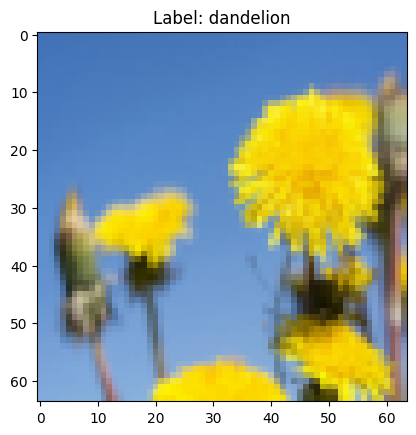

In [27]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img, label):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(f'Label: {classes[label]}')
    plt.show()

images, labels = dataset[1000]

imshow(images, labels)

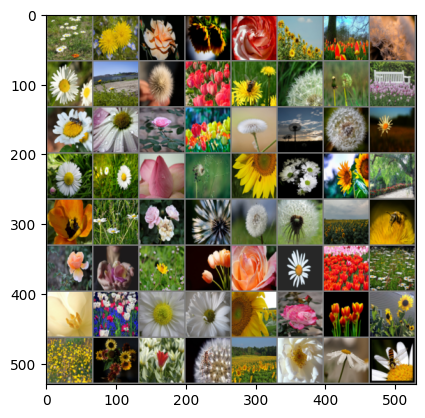

daisy dandelion rose sunflower


In [28]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(dataloader)
images, labels = next(dataiter)


imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]}' for j in range(4)))

## Классы моделей

In [31]:


#generator
class ConditionalGenerator(nn.Module):
    def __init__(self, n_classes, latent_dim, img_channels):
        super(ConditionalGenerator, self).__init__()
        self.label_emb = nn.Embedding(n_classes, latent_dim)

        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),  # 32x32
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, img_channels, 4, 2, 1, bias=False),  # 64x64
            nn.Tanh()
        )

    def forward(self, noise, labels):
        gen_input = torch.mul(self.label_emb(labels), noise)
        gen_input = gen_input.unsqueeze(2).unsqueeze(3)
        return self.model(gen_input)


In [32]:

#discriminator
class ConditionalDiscriminator(nn.Module):
    def __init__(self, n_classes, img_channels):
        super(ConditionalDiscriminator, self).__init__()
        self.label_emb = nn.Embedding(n_classes, img_channels * 64*64)

        self.model = nn.Sequential(
            nn.Conv2d(img_channels * 2, 64, 4, 2, 1, bias=False),  # 32x32
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),  # 16x16
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),  # 8x8
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),  # 4x4
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),  # 1x1
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        label_emb = self.label_emb(labels).view(img.size(0), -1,64,64)
        d_in = torch.cat((img, label_emb), 1)
        return self.model(d_in)

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [34]:
#initialization
n_classes = len(classes)
latent_dim = 100
img_channels = 3

generator = ConditionalGenerator(n_classes, latent_dim, img_channels).to(device)
discriminator =  ConditionalDiscriminator(n_classes, img_channels).to(device)
#loss
criterion = nn.BCELoss()

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Обучение

In [36]:
num_epochs = 3
d_losses, g_losses = [], []
for epoch in range(num_epochs):
    for i, (imgs, labels) in enumerate(dataloader):
        batch_size = imgs.size(0)
        real_imgs = imgs.to(device)
        labels = labels.to(device)

        #for discriminator
        optimizer_D.zero_grad()
        z = torch.randn(batch_size, latent_dim).to(device)
        fake_labels = torch.randint(0, n_classes, (batch_size,)).to(device)
        fake_imgs = generator(z, fake_labels)

        real_validity = discriminator(real_imgs, labels)
        fake_validity = discriminator(fake_imgs.detach(), fake_labels)

        real_loss = criterion(real_validity, torch.ones(batch_size, 1, 1, 1).to(device))
        fake_loss = criterion(fake_validity, torch.zeros(batch_size, 1, 1, 1).to(device))
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        #for generator
        optimizer_G.zero_grad()
        validity = discriminator(fake_imgs, fake_labels)
        g_loss = criterion(validity, torch.ones(batch_size, 1, 1, 1).to(device))
        g_loss.backward()
        optimizer_G.step()

        if i % 100 == 0:

            print(f"[Epoch {epoch+1}/{num_epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())



[Epoch 1/3] [Batch 0/68] [D loss: 0.7004898190498352] [G loss: 1.9715887308120728]
[Epoch 2/3] [Batch 0/68] [D loss: 0.19714327156543732] [G loss: 4.185216903686523]
[Epoch 3/3] [Batch 0/68] [D loss: 0.41164129972457886] [G loss: 2.815119743347168]


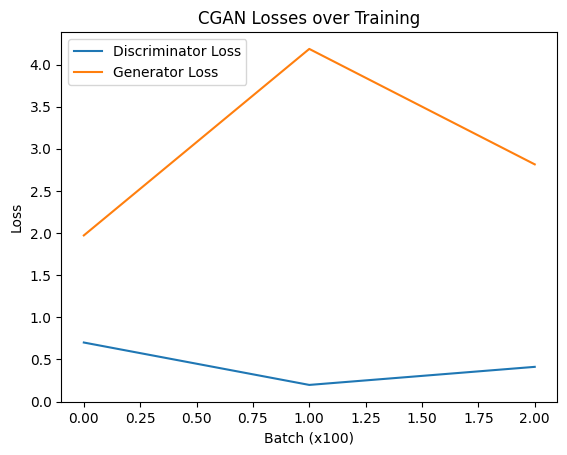

In [37]:
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.title('CGAN Losses over Training')
plt.xlabel('Batch (x100)')
plt.ylabel('Loss')
plt.legend()
plt.savefig('cgan_losses.png')
plt.show()

### Генерация и визуализация изображений цветов

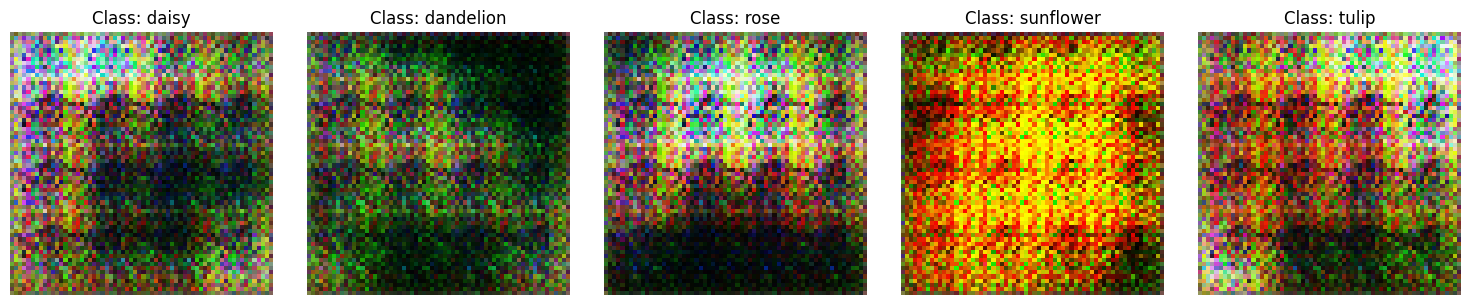

In [38]:
import matplotlib.pyplot as plt
import numpy as np

generator.eval()
n_classes = len(classes)
fig, axes = plt.subplots(1, n_classes, figsize=(15, 3))


with torch.no_grad():
    for class_idx in range(n_classes):

        z = torch.randn(1, latent_dim).to(device)
        label = torch.tensor([class_idx]).to(device)
        gen_img = generator(z, label)
        gen_img = gen_img.cpu().squeeze(0)
        gen_img = gen_img / 2 + 0.5
        gen_img = gen_img.permute(1, 2, 0).numpy()
        axes[class_idx].imshow(gen_img)
        axes[class_idx].set_title(f"Class: {classes[class_idx]}")
        axes[class_idx].axis("off")

plt.tight_layout()
plt.show()